In [25]:
import numpy as np              # Import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
from mpmath import fp as mpm
from scipy.special import j0, j1, jn_zeros, jn, yv, jv


class HankelTransform(object):
    def __init__(self, nu=0, N=200, h=0.05):
        if not np.isscalar(N):
            raise ValueError("N must be a scalar")
        if not np.isscalar(h):
            raise ValueError("h must be a scalar")
        if not np.isscalar(nu):
            raise ValueError("nu must be a scalar")

        self._nu = nu
        self._h = h
        self._zeros = self._roots(N)
        self.x = self._x(h)
        self.j = self._j(self.x)
        self.w = self._weight()
        self.dpsi = self._d_psi(h*self._zeros)

        # Some quantities only useful in the FourierTransform
        self._x_power = 1
        self._k_power = 2

    def _psi(self, t):
        y = np.sinh(t)
        return t*np.tanh(np.pi*y/2)

    def _d_psi(self, t):
        a = (np.pi*t*np.cosh(t) + np.sinh(np.pi*np.sinh(t)))/(1.0 + np.cosh(np.pi*np.sinh(t)))
        a[np.isnan(a)] = 1.0
        return a

    def _weight(self):
        return yv(self._nu, np.pi*self._zeros)/self._j1(np.pi*self._zeros)

    def _roots(self, N):
        if isinstance(self._nu, int):
            return jn_zeros(self._nu, N)/np.pi
        elif self._nu == 0.5:
            return np.arange(1, N + 1)
        else:
            return np.array([mpm.besseljzero(self._nu, i + 1) for i in range(N)])/np.pi

    def _j(self, x):
        if self._nu == 0:
            return j0(x)
        elif self._nu == 1:
            return j1(x)
        elif isinstance(self._nu, int):
            return jn(self._nu, x)
        else:
            return jv(self._nu, x)

    def _j1(self, x):
        if self._nu == -1:
            return j0(x)
        elif self._nu == 0:
            return j1(x)
        elif isinstance(self._nu, int):
            return jn(self._nu + 1, x)
        else:
            return jv(self._nu + 1, x)

    def _x(self, h):
        return np.pi*self._psi(h*self._zeros)/h

    def _f(self, f, x):
        return f(x)

    @staticmethod
    def _k(k):
        return k

    @staticmethod
    def _norm(self,inverse=False):
        return 1

    def transform(self, f, k=1, ret_err=True, ret_cumsum=False, inverse=False):
        # The following allows for a re-scaling of k when doing FT's.
        k = self._k(k)

        # The following is the scalar normalisation of the transform
        # The basic transform has a norm of 1, but when doing FT's, this depends on the dimensionality.
        norm = self._norm(inverse)

        # The following renormalises by the fourier dual to some power
        knorm = k ** self._k_power

        fres = self._f(f, np.divide.outer(self.x, k).T)*self.x**self._x_power
        summation = np.pi*self.w*fres*self.j*self.dpsi
        ret = norm * np.sum(summation, axis=-1)/knorm

        if ret_err:
            err = norm * np.take(summation, -1, axis=-1)/knorm
        if ret_cumsum:
            cumsum = norm * np.divide.outer(np.cumsum(summation, axis=-1),knorm)

        if ret_err and ret_cumsum:
            return ret, err, cumsum
        elif ret_err:
            return ret, err
        elif ret_cumsum:
            return ret, cumsum
        else:
            return ret

    def integrate(self, f, ret_err=True, ret_cumsum=False):
        return self.transform(f=lambda x: f(x)/x, k=1, ret_err=ret_err, ret_cumsum=ret_cumsum, inverse=False)


class SymmetricFourierTransform(HankelTransform):
    def __init__(self, ndim=2, a = 1, b = 1, N=200, h=0.05):
        if ndim%2 == 0:
            nu = ndim/2 - 1
        else:
            nu = ndim/2. - 1

        self.ndim = ndim
        self.fourier_norm_a = a
        self.fourier_norm_b = b

        super(SymmetricFourierTransform, self).__init__(nu=nu, N=N, h=h)

        self._x_power = self.ndim/2.
        self._k_power = self.ndim

    def _fourier_norm(self,inverse=False):
        if inverse:
            return np.sqrt(np.abs(self.fourier_norm_b)/(2*np.pi)**(1+self.fourier_norm_a))**self.ndim
        else:
            return np.sqrt(np.abs(self.fourier_norm_b)/(2*np.pi) ** (1 - self.fourier_norm_a))**self.ndim

    def _norm(self,inverse=False):
        return (2*np.pi) ** (self.ndim/2.) * self._fourier_norm(inverse)


In [27]:
from hankel.hankel import HankelTransform

In [28]:
ht = HankelTransform(nu= 0,            # The order of the bessel function
                     N = 120,          # Number of steps in the integration
                     h = 0.03)         # Proxy for "size" of steps in integrationы

In [29]:
f = lambda x : x/(x**2 + 1)

In [30]:
t = np.linspace(-1, 1, 120)
f=f(t)

In [31]:
k = np.logspace(-1,1,50)
Fk = ht.transform(f,k,ret_err=bool)

TypeError: 'numpy.ndarray' object is not callable

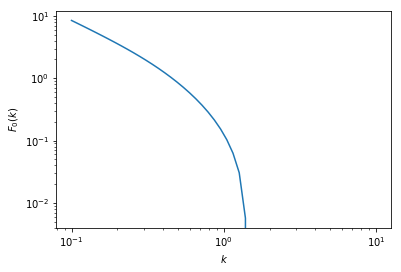

In [19]:
plt.plot(k,Fk)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$F_0(k)$")
plt.xlabel(r"$k$")
plt.show()